# Chapter 11: GANs - MINST

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [6]:
%cd '/content/gdrive/MyDrive/LDS8_K275_ONLINE_DinhVietTrung/Chapter_11_GNN/mnist'

/content/gdrive/MyDrive/LDS8_K275_ONLINE_DinhVietTrung/Chapter_11_GNN/mnist


In [3]:
# pip install tqdm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Convolution2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

In [15]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
# np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
random_dim = 100

In [16]:
#load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(60000, 784)

In [17]:
# function doc du lieu
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [18]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

In [19]:
def get_generator(optimizer):
    # LeakyReLU: ReLU mà có giá trị âm á
    generator = Sequential()
    generator.add(Dense(256, 
                        input_dim=random_dim, 
                        kernel_initializer=initializers.RandomNormal(stddev=0.02))) #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal
    generator.add(LeakyReLU(0.2)) #https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU, Leaky ReLUs allow a small, positive gradient when the unit is not active

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator

In [20]:
def get_discriminator(optimizer):
    discriminator = Sequential()

    discriminator.add(Dense(1024, 
                            input_dim=784, 
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

In [21]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False 
    # since we only want to train either the generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,)) 
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [22]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim]) # random_dim = 100
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')        
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [23]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        # tao thanh process bar: https://tqdm.github.io/
        for _ in tqdm(range(int(batch_count))): 
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size) # 
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
        # in ket qua ra file: # save_generated_images(e, generator)

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.98it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.77it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.79it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.62it/s]


--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.24it/s]


--------------- Epoch 6 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.82it/s]


--------------- Epoch 7 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.79it/s]


--------------- Epoch 8 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.72it/s]


--------------- Epoch 9 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.92it/s]


--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.81it/s]


--------------- Epoch 11 ---------------


100%|██████████| 468/468 [00:31<00:00, 15.03it/s]


--------------- Epoch 12 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.24it/s]


--------------- Epoch 13 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.25it/s]


--------------- Epoch 14 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.27it/s]


--------------- Epoch 15 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.87it/s]


--------------- Epoch 16 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.77it/s]


--------------- Epoch 17 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.51it/s]


--------------- Epoch 18 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.40it/s]


--------------- Epoch 19 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.68it/s]


--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.52it/s]


--------------- Epoch 21 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.71it/s]


--------------- Epoch 22 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.64it/s]


--------------- Epoch 23 ---------------


100%|██████████| 468/468 [00:31<00:00, 15.01it/s]


--------------- Epoch 24 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.34it/s]


--------------- Epoch 25 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.37it/s]


--------------- Epoch 26 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.38it/s]


--------------- Epoch 27 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.90it/s]


--------------- Epoch 28 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.96it/s]


--------------- Epoch 29 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.65it/s]


--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.92it/s]


--------------- Epoch 31 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.72it/s]


--------------- Epoch 32 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.27it/s]


--------------- Epoch 33 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.24it/s]


--------------- Epoch 34 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.62it/s]


--------------- Epoch 35 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.30it/s]


--------------- Epoch 36 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.62it/s]


--------------- Epoch 37 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.68it/s]


--------------- Epoch 38 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.85it/s]


--------------- Epoch 39 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.26it/s]


--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.82it/s]


--------------- Epoch 41 ---------------


100%|██████████| 468/468 [00:30<00:00, 15.34it/s]


--------------- Epoch 42 ---------------


100%|██████████| 468/468 [00:31<00:00, 14.92it/s]


--------------- Epoch 43 ---------------


100%|██████████| 468/468 [00:29<00:00, 15.61it/s]


--------------- Epoch 44 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.36it/s]


--------------- Epoch 45 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.64it/s]


--------------- Epoch 46 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.93it/s]


--------------- Epoch 47 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.53it/s]


--------------- Epoch 48 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.25it/s]


--------------- Epoch 49 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.14it/s]


--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.18it/s]


--------------- Epoch 51 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.52it/s]


--------------- Epoch 52 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.00it/s]


--------------- Epoch 53 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.01it/s]


--------------- Epoch 54 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.08it/s]


--------------- Epoch 55 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.74it/s]


--------------- Epoch 56 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.95it/s]


--------------- Epoch 57 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.52it/s]


--------------- Epoch 58 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.87it/s]


--------------- Epoch 59 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.86it/s]


--------------- Epoch 60 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.48it/s]


--------------- Epoch 61 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.70it/s]


--------------- Epoch 62 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.88it/s]


--------------- Epoch 63 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.00it/s]


--------------- Epoch 64 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.09it/s]


--------------- Epoch 65 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.20it/s]


--------------- Epoch 66 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.23it/s]


--------------- Epoch 67 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.65it/s]


--------------- Epoch 68 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.18it/s]


--------------- Epoch 69 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.03it/s]


--------------- Epoch 70 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.09it/s]


--------------- Epoch 71 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.23it/s]


--------------- Epoch 72 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.72it/s]


--------------- Epoch 73 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.13it/s]


--------------- Epoch 74 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.07it/s]


--------------- Epoch 75 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.19it/s]


--------------- Epoch 76 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.14it/s]


--------------- Epoch 77 ---------------


100%|██████████| 468/468 [00:25<00:00, 18.70it/s]


--------------- Epoch 78 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.12it/s]


--------------- Epoch 79 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.18it/s]


--------------- Epoch 80 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.13it/s]


--------------- Epoch 81 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.15it/s]


--------------- Epoch 82 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.99it/s]


--------------- Epoch 83 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.12it/s]


--------------- Epoch 84 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.22it/s]


--------------- Epoch 85 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.74it/s]


--------------- Epoch 86 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.94it/s]


--------------- Epoch 87 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.19it/s]


--------------- Epoch 88 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.17it/s]


--------------- Epoch 89 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.16it/s]


--------------- Epoch 90 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.21it/s]


--------------- Epoch 91 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.72it/s]


--------------- Epoch 92 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.16it/s]


--------------- Epoch 93 ---------------


100%|██████████| 468/468 [00:24<00:00, 18.92it/s]


--------------- Epoch 94 ---------------


100%|██████████| 468/468 [00:24<00:00, 19.03it/s]


--------------- Epoch 95 ---------------


100%|██████████| 468/468 [00:26<00:00, 17.43it/s]


--------------- Epoch 96 ---------------


100%|██████████| 468/468 [00:27<00:00, 16.99it/s]


--------------- Epoch 97 ---------------


100%|██████████| 468/468 [00:28<00:00, 16.57it/s]


--------------- Epoch 98 ---------------


 52%|█████▏    | 245/468 [00:14<00:12, 17.24it/s]


KeyboardInterrupt: ignored

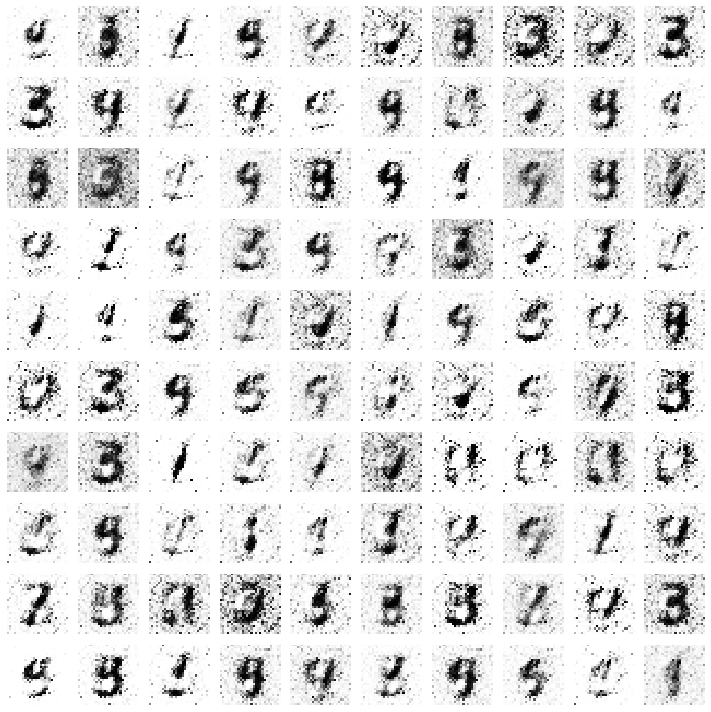

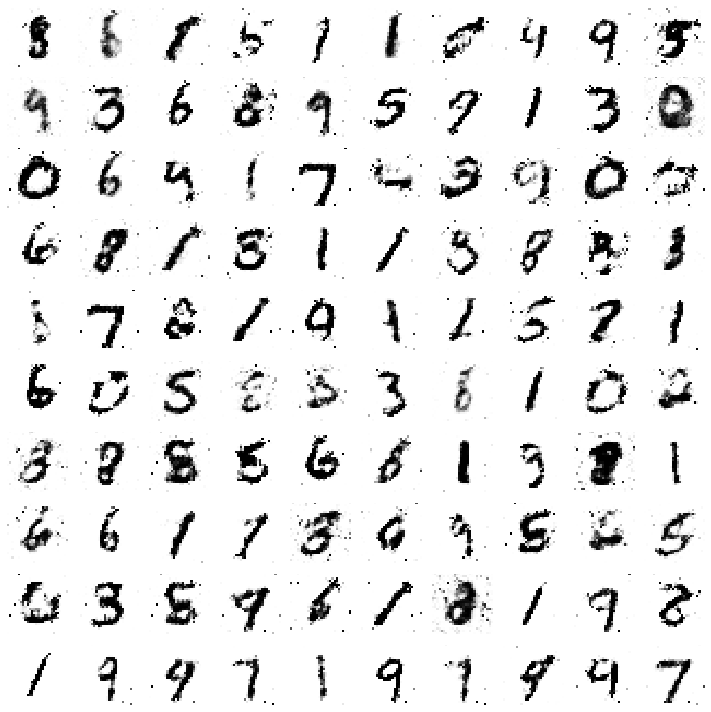

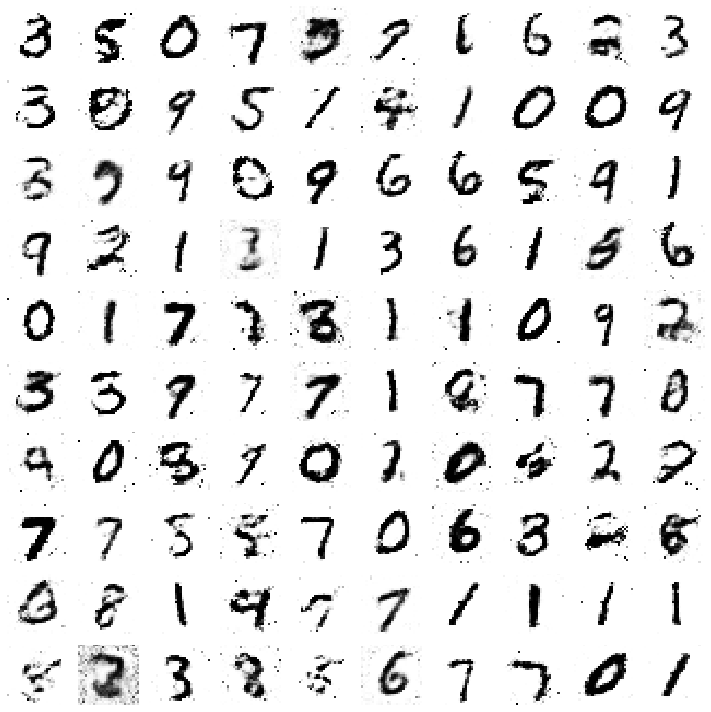

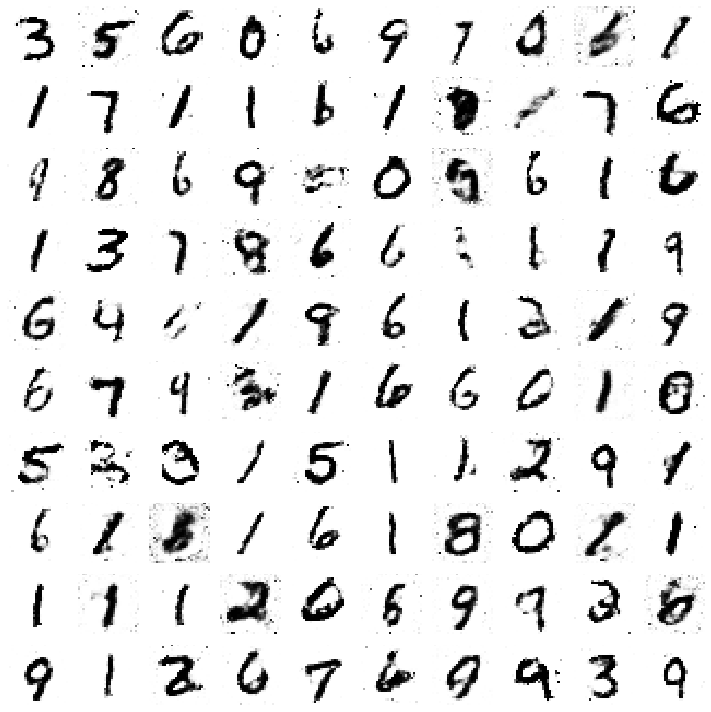

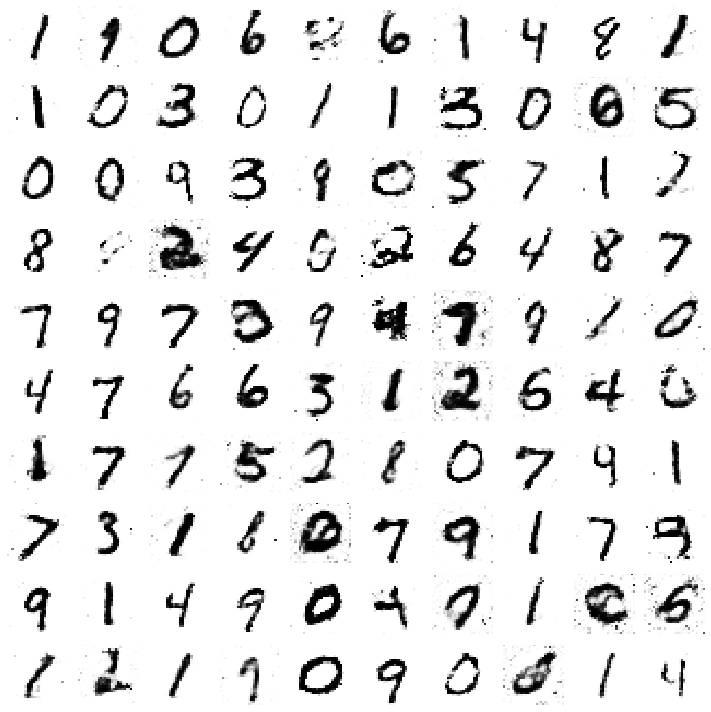

In [24]:
train(300, 128) # chay epoch = 300, batch = 128